In [3]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from random import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from ResNet import ResidualUnit
from Inception import InceptionUnit
from Xception import XceptionUnit

In [ ]:
def createFilelist(mydir):
    Filelist=[]
    for root,dirs,files in os.walk(mydir,topdown=False): 
        for name in files:
            fullname=os.path.join(root,name)
            Filelist.append(fullname)
    return Filelist

In [ ]:
def resize(img):
    old_image_height, old_image_width, channels = img.shape
    # create new image of desired size and color (blue) for padding
    new_image_width = 224
    new_image_height = 224
    color = (0,0,0)
    result = np.full((new_image_height,new_image_width, channels), color, dtype=np.uint8)

    # compute center offset
    x_center = (new_image_width - old_image_width) // 2
    y_center = (new_image_height - old_image_height) // 2

    # copy img image into center of result image
    result[y_center:y_center+old_image_height, x_center:x_center+old_image_width] = img
    return result

In [ ]:
negativeList=createFilelist(r"D:\Programming\Python\Tender-Notice-Extraction\Datasets\0")
positiveList=createFilelist(r"D:\Programming\Python\Tender-Notice-Extraction\Datasets\1")

In [ ]:
datasets = []
for img in negativeList:
    img = cv2.imread(img)
    img = resize(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img.astype('float32')
    img = img / 255.0
    img = np.reshape(img, (224, 224, 1))
    datasets.append([img, [1, 0]])
print("now positive")
for img  in positiveList:
    img = cv2.imread(img)
    img = resize(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img.astype('float32')
    img = img / 255.0
    img = img.reshape(224, 224, 1)
    datasets.append([img, [0, 1]])

In [ ]:
new_datasets = np.array(datasets)

In [4]:
# np.save('D:\Programming\Python\Tender-Notice-Extraction\source\logs\datasets.npy', new_datasets)
new_datasets = np.load('D:\Programming\Python\Tender-Notice-Extraction\source\logs\datasets.npy', allow_pickle=True)

In [5]:
np.random.shuffle(new_datasets)

In [6]:
X = []
y = []
for ele in new_datasets:
    X.append(ele[0])
    y.append(ele[1])
X = np.array(X)
y = np.array(y)

[0 1]


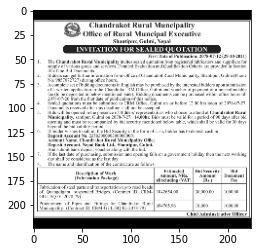

In [7]:
print(y[0])
plt.imshow(X[0], cmap="gray")

In [8]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42) 

In [9]:
model_resnet = keras.models.Sequential()
model_resnet.add(keras.layers.Conv2D(4, 7, strides = 2, input_shape = [224, 224, 1], padding = "same", use_bias = False))
model_resnet.add(keras.layers.BatchNormalization())
model_resnet.add(keras.layers.Activation("relu"))
model_resnet.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding = "same"))
model_resnet.add(ResidualUnit(3, strides = 2))
model_resnet.add(keras.layers.Flatten())
model_resnet.add(keras.layers.Dropout(0.5))
model_resnet.add(keras.layers.Dense(10, activation = "relu"))
model_resnet.add(keras.layers.Dense(2, activation = "softmax"))

In [10]:
optimizer = keras.optimizers.SGD(learning_rate=0.01)
model_resnet.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=optimizer, metrics=["accuracy"])

In [11]:
# NAME = "tender-cnn1-{}".format(int(time.time()))
# tensorboard = keras.callbacks.TensorBoard(log_dir=f"logs/Xception{NAME}", histogram_freq=0, write_graph=True, write_images=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
# checkpoint_cb = keras.callbacks.ModelCheckpoint(f"models/Xception{NAME}.h5", save_best_only=True)

In [14]:
history = model_resnet.fit(X_train, y_train,
                            epochs=30,
                            validation_data=(X_valid, y_valid),
                            callbacks=[early_stopping_cb])  

Epoch 1/30
184/184 [==============================] - 2s 13ms/step - loss: 0.0101 - accuracy: 0.9971 - val_loss: 0.0177 - val_accuracy: 0.9952
Epoch 2/30
184/184 [==============================] - 2s 11ms/step - loss: 0.0063 - accuracy: 0.9978 - val_loss: 0.0208 - val_accuracy: 0.9925
Epoch 3/30
184/184 [==============================] - 2s 11ms/step - loss: 0.0073 - accuracy: 0.9973 - val_loss: 0.0349 - val_accuracy: 0.9898
Epoch 4/30
184/184 [==============================] - 2s 11ms/step - loss: 0.0065 - accuracy: 0.9976 - val_loss: 0.0364 - val_accuracy: 0.9905
Epoch 5/30
184/184 [==============================] - 2s 11ms/step - loss: 0.0054 - accuracy: 0.9983 - val_loss: 0.2399 - val_accuracy: 0.9081
Epoch 6/30
184/184 [==============================] - 2s 11ms/step - loss: 0.0079 - accuracy: 0.9969 - val_loss: 0.0366 - val_accuracy: 0.9905
Epoch 7/30
184/184 [==============================] - 2s 11ms/step - loss: 0.0048 - accuracy: 0.9983 - val_loss: 0.0171 - val_accuracy: 0.9918

In [15]:
model_resnet.evaluate(X_test, y_test)

58/58 [==============================] - 0s 6ms/step - loss: 0.0146 - accuracy: 0.9951


[0.01460430771112442, 0.995100736618042]

In [16]:
model_resnet.save("D:\Programming\Python\Tender-Notice-Extraction\source\models\model.h5")